<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第四章：聚类
湖北理工学院《机器学习》课程资料

作者：李辉楚吴

笔记内容概述: 电影评分分析中的聚类问题及应用


Moves Data File Structure (movies.csv)

Genres: (no genres listed), 动作（Action）, 冒险（Adventure）, 动画（Animation）, 儿童（Children）, 喜剧（Comedy）, 犯罪（Crime）, 纪录片（Documentary）, 剧情（Drama）, 奇幻（Fantasy）, 黑色电影（Film-Noir）, 恐怖（Horror）, IMAX, 音乐（Musical）, 推理（Mystery）, 爱情（Romance）, 科幻（Sci-Fi）, 惊悚（Thriller）, 战争（War）, 西部（Western）

In [29]:
import pandas as pd
import numpy as np

movies = pd.read_csv('./Data/movies.csv')
print(f'Movie number: {len(movies)}')
movies.head()

Movie number: 9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
# Statistic genres
genres_list = []
for genres in movies['genres']:
    genres_list.extend(genres.split('|'))
genres_list = np.sort(np.unique(genres_list))
print(f'Movie genres: {genres_list}')

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

Movie genres: ['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


Rating Data File Structure (ratings.csv)

Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

userId, movieId, rating, timestamp

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [3]:
ratings = pd.read_csv('./Data/ratings.csv')
user_list = np.sort(np.unique(ratings['userId']))
print(f'{len(user_list)} have provided {len(ratings)} rate records')
ratings.head()

610 have provided 100836 rate records


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 用DBSCAN进行聚类，分析主要用户群体

统计用户对各种电影类型的喜爱程度，即计算用户对各类电影的平均分

In [10]:
# Create an array to save rates of all genres
user_genres_rate = np.zeros((len(user_list), len(genres_list)))

# Create an array to save movie rating counts of all genres
# To compute average rates
user_genres_rate_counts = np.zeros((len(user_list), len(genres_list)))

for i in range(len(ratings)):
    # User ID start from 1
    # Convert user ID to user_idx by minus 1
    user_idx = int(ratings.iloc[i]['userId'] - 1)
    
    # Get rate
    rate = ratings.iloc[i]['rating']

    # Get target movie
    movie_id = ratings.iloc[i]['movieId']

    # Split movie genres string
    genres_type = movies[movies['movieId'] == movie_id]['genres'].values[0]
    genres_type = genres_type.split('|')

    # Statistic rates of movie genres
    for genres in genres_type:
        # Using '[0][0]' to get index from a list tuple
        # First [0] get the index list outputed by np.where()
        # Second [0] get the first item of list (with single item)
        genres_idx = np.where(genres_list == genres)[0][0]

        # Sum rate
        user_genres_rate[user_idx, genres_idx] += rate
        
        # Count movie number of the genres
        user_genres_rate_counts[user_idx, genres_idx] += 1

# Compute genres rates of all users
user_genres_rate = user_genres_rate / user_genres_rate_counts

C:\Users\credo\AppData\Local\Temp\ipykernel_138260\4084477273.py:37: RuntimeWarning: invalid value encountered in divide
  user_genres_rate = user_genres_rate / user_genres_rate_counts


用散点图展示动作电影（Action）和动画电影（Animation）的用户喜爱情况

可选电影类型: 

'(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'

'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'

'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western'

Number of users who watched both Action and Animation: 526
Shape of x: (526, 2)


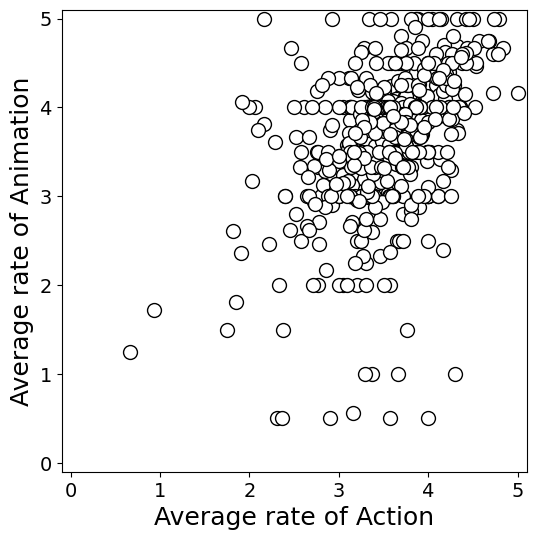

In [11]:
import matplotlib.pyplot as plt

genres_1 = 'Action' # Define first genres
genres_2 = 'Animation' # Define second genres

idx_g1 = np.where(genres_list == genres_1)[0][0] # Get genres 1 index in the genres_list
idx_g2 = np.where(genres_list == genres_2)[0][0] # Get genres 2 index in the genres_list

# Get list of user who have watched movies including both genres_1 and genres_2
# Idea: People who have watched related movies are more credible in determining whether they like them or not.
idx_both = np.where(np.logical_and(user_genres_rate[:,idx_g1] > 0, user_genres_rate[:,idx_g2] > 0))[0]
print(f'Number of users who watched both {genres_1} and {genres_2}: {len(idx_both)}')

# Filter rating information of users who have watched both genres_1 and genres_2
x = user_genres_rate[idx_both][:, [idx_g1, idx_g2]]
print(f'Shape of x: {x.shape}')

# Drawing rates distribution by scatter figure
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(x[:,0], x[:,1], marker="o", c='white', s=10**2, edgecolor="k")

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
ax.set_xlabel(f'Average rate of {genres_1}', fontsize=label_size)
ax.set_ylabel(f'Average rate of {genres_2}', fontsize=label_size)
ax.set_xlim([-0.1, 5.1])
ax.set_ylim([-0.1, 5.1])
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
# plt.savefig(f'rate_of_interested_movies.png', dpi=300) # Make figure clearer
plt.show()

使用曼哈顿距离计算各点之间的距离矩阵

* 可用循环的方式实现，但是运行速度比较慢

In [12]:
# Convert x to 3-D by adding a new axis
x_exp = x[:, np.newaxis]
print('The shape of x_exp is', x_exp.shape)

# Compute diff vector matrix by numpy's broadcast machanism
x_diff = x[:, np.newaxis] - x
print('The shape of x_diff', x_diff.shape)

# Sum difference to compute Manhattan distance
distance_map = np.abs(x_diff).sum(axis=2)
print('The shape of distance_map', distance_map.shape)

The shape of x_exp is (526, 1, 2)
The shape of x_diff (526, 526, 2)
The shape of distance_map (526, 526)


绘制min-pts为3时的k-Distance图，判断合适的eps所处区间

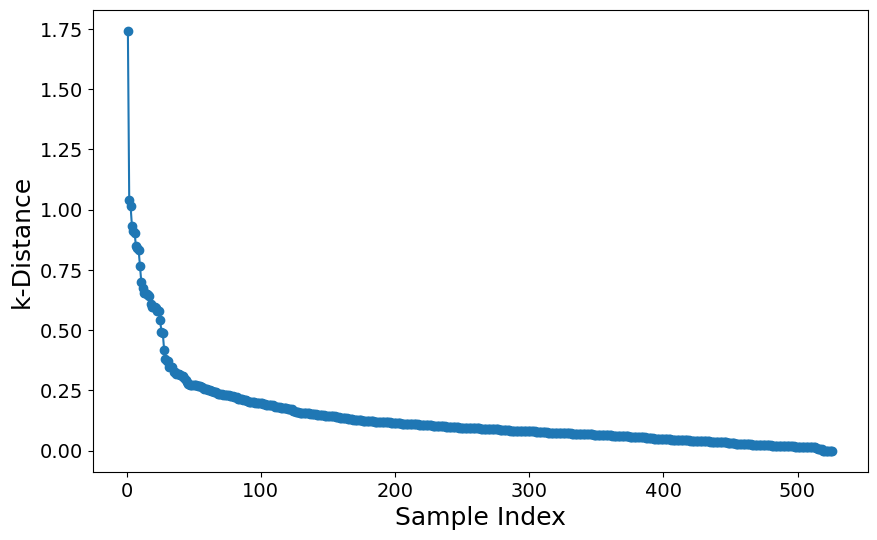

In [13]:
# Using k-Distance to find potential values of e
min_pts = 3

# k-Distance
k_distance = np.sort(np.sort(distance_map, axis=1)[:, min_pts])[::-1]

# Draw k-Distance figure
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(1, len(k_distance)+1), k_distance, marker='o', linestyle='-', color='tab:blue')
ax.set_xlabel('Sample Index', fontsize=label_size)
ax.set_ylabel('k-Distance', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
# plt.savefig(f'rate_dbscan_kdistance.png', dpi=300)
plt.show()

令eps为0.25进行密度聚类，获取主要受众群体

Biggest cluster label: 0


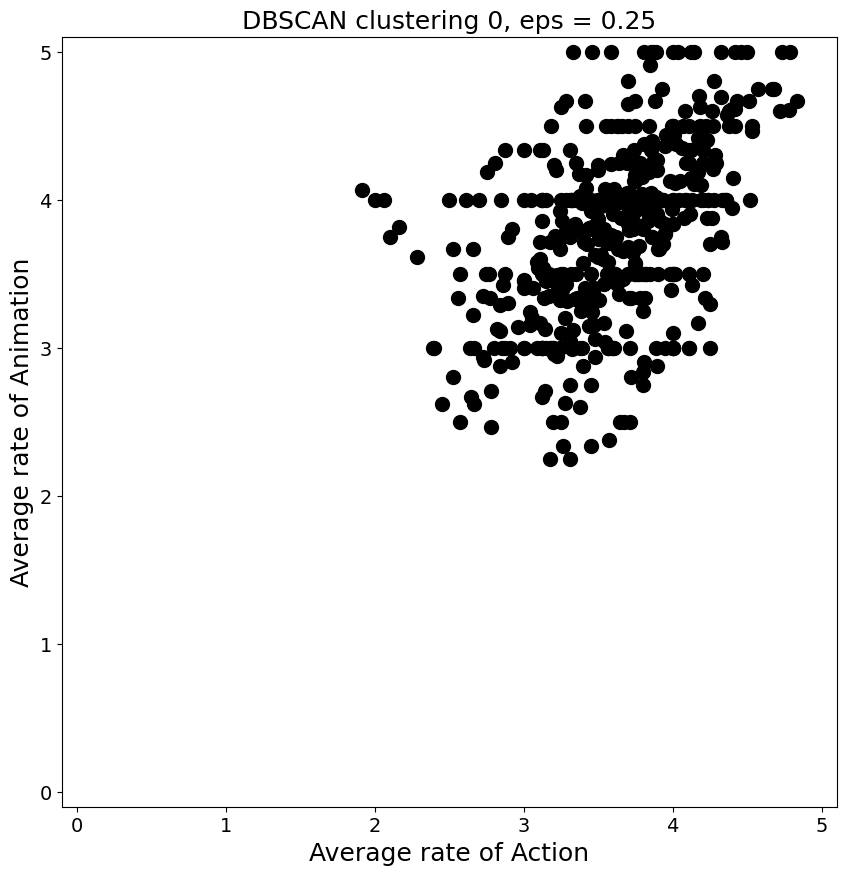

In [14]:
from sklearn.cluster import DBSCAN

eps = 0.25

# Define DBSCAN clustering model
mdl_dbscan = DBSCAN(eps=eps, min_samples=min_pts)

# Train k-Means model
mdl_dbscan.fit(x)

labels_dbscan = mdl_dbscan.labels_

# Get the biggest cluster from labels_dbscan
# Filter out noise points (labels = -1) before using np.bincount()
biggest_cluster_label = np.argmax(np.bincount(labels_dbscan[labels_dbscan != -1]))
print(f'Biggest cluster label: {biggest_cluster_label}')

# Plot scatter of average rates
fig, ax = plt.subplots(figsize=(10,10))

# Draw noise points
point_idx = (labels_dbscan == biggest_cluster_label)
ax.scatter(x[point_idx,0], x[point_idx,1], marker="o", c="k", s=10**2, edgecolor="k", zorder=0)

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
ax.set_xlabel(f'Average rate of {genres_1}', fontsize=label_size)
ax.set_ylabel(f'Average rate of {genres_2}', fontsize=label_size)
ax.set_xlim([-0.1, 5.1])
ax.set_ylim([-0.1, 5.1])
ax.set_title(f'DBSCAN clustering {biggest_cluster_label}, eps = {eps}', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
# plt.savefig(f'rate_dbscan_cluster_{biggest_cluster_label}.png', dpi=300) # Make figure clearer
plt.show()

### 使用协同过滤对主要群体做个性化推荐

根据聚类结果以最大类（主要群体）构建新数据集user_movie_rate_table

In [108]:
# Get rate of users in cluster biggest_cluster_label
user_ratings = ratings[ratings['userId'].isin(idx_both[labels_dbscan == biggest_cluster_label])]
print('Number of users:', len(user_ratings['userId'].unique()))

# Get list of movies which have been watched by users in user_ratings
watched_movies = user_ratings['movieId'].unique()
print('Number of watched movies:', len(watched_movies))

# Filter out movies which are not genres_1 nor genres_2 from watched_movies
filtered_movies = movies[movies['movieId'].isin(watched_movies) & 
                         (movies['genres'].str.contains(genres_1) | 
                          movies['genres'].str.contains(genres_2))]
print('Number of filtered movies:', len(filtered_movies))

# Only select 450 movies just to reduce computation time
filtered_movies = filtered_movies.head(450)
print('Number of selected movies:', len(filtered_movies))

# Union rates and filtered_movies tables by 'movieId'
user_movie_rate_table = pd.merge(user_ratings, filtered_movies, on='movieId')
user_movie_rate_table.head()

Number of users: 486
Number of watched movies: 8867
Number of filtered movies: 2106
Number of selected movies: 450


,userId,movieId,rating,timestamp,title,genres
0,3,647,0.5,1306463619,Courage Under Fire (1996),Action|Crime|Drama|War
1,3,688,0.5,1306464228,Operation Dumbo Drop (1995),Action|Adventure|Comedy|War
2,3,720,0.5,1306463595,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
3,3,849,5.0,1306463611,Escape from L.A. (1996),Action|Adventure|Sci-Fi|Thriller
4,3,1275,3.5,1306463323,Highlander (1986),Action|Adventure|Fantasy


由user_movie_rate_table生成用户相似度表user_movie_rate_array

In [109]:
# Get userID list
user_list = user_movie_rate_table['userId'].unique()
print(f'User number is {len(user_list)}')

# Get movieID list
movie_list = user_movie_rate_table['movieId'].unique()
print(f'Movie number is {len(movie_list)}')

# Generate user_movie_rate_array
# Create a 2D array to store user-movie ratings
user_movie_rate_array = np.zeros((len(user_list), len(movie_list)))

# Fill the array with ratings
for index, row in user_movie_rate_table.iterrows():
    user_index = np.where(user_list == row['userId'])[0][0]
    movie_index = np.where(movie_list == row['movieId'])[0][0]
    
    user_movie_rate_array[user_index, movie_index] = row['rating']

print(f"Shape of user_movie_rate_array: {user_movie_rate_array.shape}")

User number is 476
Movie number is 450
Shape of user_movie_rate_array: (476, 450)


使用热力图展示user_movie_rate_array

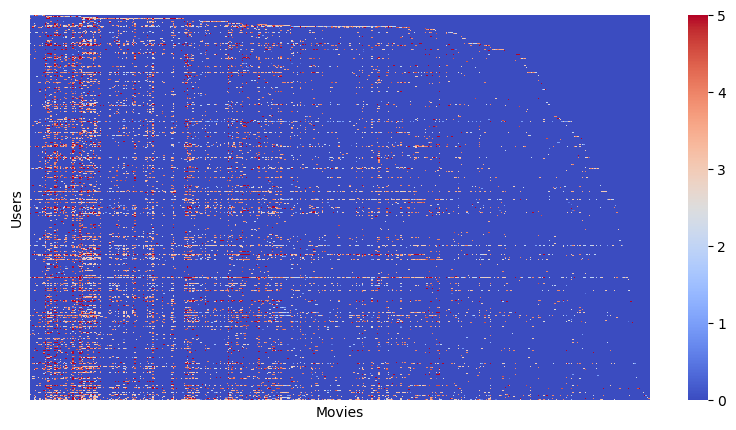

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 5))

# Create the heatmap
sns.heatmap(user_movie_rate_array, cmap='coolwarm', xticklabels=False, yticklabels=False)

# Set title and labels
plt.xlabel('Movies')
plt.ylabel('Users')

# Show the plot
plt.show()


记录所有未评分的电影

In [112]:
# Create a dictionary to store unrated movies for each user
unrated_movies = {}
unrated_movies_count = 0
print(user_movie_rate_array.shape)
# Iterate through each user
for user_idx, user_ratings in enumerate(user_movie_rate_array):
    # Find indices of unrated movies (where rating is 0)
    unrated_indices = np.where(user_ratings < 0.1)[0]
    
    # Store the unrated movie IDs for this user
    # Keys and values are the index of user_movie_rate_array
    unrated_movies[user_idx] = unrated_indices
    
    if  isinstance(unrated_indices, int):        
        unrated_movies_count += 1
    else:
        unrated_movies_count += unrated_indices.size

print(f"Number of users with unrated user-movies: {unrated_movies_count}")

(476, 450)
Number of users with unrated user-movies: 199863


使用余弦相似度，由user_movie_rate_array生成sim_matrix

In [113]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(user_movie_rate_array)
print(f"Size of sim_matrix is: {sim_matrix.shape}")

Size of sim_matrix is: (476, 476)


使用sim_matrix预测电影评分

In [114]:
# Function to predict ratings for unrated movies
def predict_ratings(user_idx, unrated_indices, sim_matrix, user_movie_rate_array, k=10):
    # Get the similarity scores for the current user
    user_similarities = sim_matrix[user_idx]
    
    # Sort similarities in descending order and get top k similar users
    similar_users = np.argsort(user_similarities)[::-1][1:k+1]
    
    predicted_ratings = []
    
    for movie_idx in unrated_indices:
        # Get ratings of similar users for this movie
        similar_user_ratings = user_movie_rate_array[similar_users, movie_idx]
        
        # Filter out users who haven't rated this movie
        valid_ratings = similar_user_ratings[similar_user_ratings > 0]
        valid_similarities = user_similarities[similar_users][similar_user_ratings > 0]
        
        if len(valid_ratings) > 0:
            # Weighted average of ratings
            predicted_rating = np.sum(valid_ratings * valid_similarities) / np.sum(valid_similarities)
        else:
            # If no similar user has rated this movie, use the global mean rating
            predicted_rating = np.mean(user_movie_rate_array[user_movie_rate_array > 0])
        
        predicted_ratings.append(predicted_rating)
    
    return predicted_ratings

# Predict ratings for all users
predicted_ratings = {}
for user_idx, unrated_indices in unrated_movies.items():
    predicted_ratings[user_idx] = predict_ratings(user_idx, unrated_indices, sim_matrix, user_movie_rate_array)

# Print some statistics
total_predictions = sum(len(ratings) for ratings in predicted_ratings.values())
print(f"Total number of predictions made: {total_predictions}")
print(f"Average predicted rating: {np.mean([rating for user_ratings in predicted_ratings.values() for rating in user_ratings]):.2f}")

# Update user_movie_rate_array with predicted ratings
for user_idx, user_predictions in predicted_ratings.items():
    user_movie_rate_array[user_idx, unrated_movies[user_idx]] = user_predictions

print("Updated user_movie_rate_array with predicted ratings.")



Total number of predictions made: 199863
Average predicted rating: 3.42
Updated user_movie_rate_array with predicted ratings.


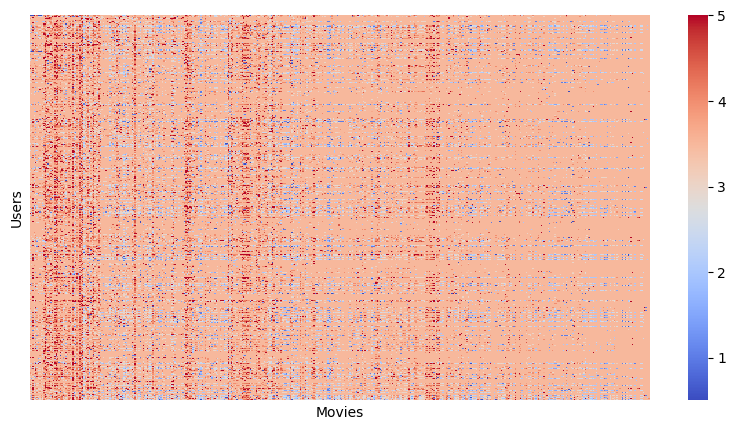

In [115]:
# Set up the plot
plt.figure(figsize=(10, 5))

# Create the heatmap
sns.heatmap(user_movie_rate_array, cmap='coolwarm', xticklabels=False, yticklabels=False)

# Set title and labels
plt.xlabel('Movies')
plt.ylabel('Users')

# Show the plot
plt.show()